## Web Mining - TP Stocks - Grupo 4

### Librerias

In [ ]:
import pandas as pd
import nltk
nltk.download('stopwords')
import spacy # Python 3.12
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Archivo entrenamiento

In [ ]:
data = pd.read_excel('YPF UNIFICADO VERIFICADO V10.xlsx', sheet_name= 'NOTICIAS')

## Preprocesamiento

In [ ]:
def get_day_of_week(date_string):
    date_object = datetime.strptime(date_string, '%d-%m-%Y')

    day_of_week = date_object.weekday()

    days = ["Lunes", "Martes", "Miércoles", "Jueves", "Viernes", "Sábado", "Domingo"]
    day_of_week_string = days[day_of_week]

    return day_of_week_string

In [ ]:
data['DIA'] = data['DIA'].dt.day_name()

### Stopwords

In [ ]:
stopwords_en = set(stopwords.words('english'))

In [ ]:
# Listado de stopwords propio
stopwords_personales = ['Refinitiv','Zacks','Rystad','Andrew','Rocco','Nilanjan','Benerjee','CERAWEEK','Tirthankar','Chakraborty','Anindya','Barman','Scott','Squires','Jonathan','Gilbert','Yvonne','Yue','Li'
                        'Laura','Millan','Jorgelina','Do','Rosario']

stopwords_personales = [x.lower() for x in stopwords_personales]

stopwords_custom = list(stopwords_en.union(stopwords_personales))

### Bag Of Words

In [ ]:
word_count = {}

for sentence in data[data['Category'].isin(['Compra'])]['Text'].to_list():
    words = sentence.split()

    for word in words:
        word = word.strip(".,!?()").lower()

        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

In [ ]:
word_count_filtro = {word: count for word, count in word_count.items() if word not in stopwords_en}

In [ ]:
word_counts_orden = dict(sorted(word_count_filtro.items(), key=lambda x: x[1], reverse=True))

In [ ]:
df = pd.DataFrame(list(word_counts_orden.items()), columns=['Palabra', 'Frecuencia'])
file_path = 'bag_of_words.xlsx'
df.to_excel(file_path, index=False)

### Función de Lematización

In [ ]:
import en_core_web_sm

In [ ]:
def func_lemma(X_train, dicc_stopwords):

    nlp = spacy.load("en_core_web_sm")
    #pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

    X_train_lemma = []

    for noticia in X_train:
        l_doc = nlp(noticia)
        v_lema = " ".join([token.lemma_.lower() for token in l_doc if token.text.lower() not in dicc_stopwords and not token.is_punct])
        X_train_lemma.append(v_lema)

    return X_train_lemma

### Split Train / Test

In [ ]:
data_train = data[data['Train/Test'].isin(['Train'])]
data_test = data[data['Train/Test'].isin(['Test'])]

In [ ]:
data_train

,Pagina,Text,DIA,YPF?,Fecha,Balance,Category,Train/Test
0,ZACKS,Do Options Traders Know Something About YPF So...,Wednesday,SI,2021-01-06,0,Compra,Train
1,BLOOMBERG,"Crop U-Turn in Argentina Ruffles Importers, La...",Thursday,NO,2021-01-14,0,Neutro,Train
2,BLOOMBERG,"Oaktree, BlackRock Are Said to Be Among YPF Cr...",Monday,SI,2021-01-18,0,Neutro,Train
3,BLOOMBERG,YPF Stuns Bondholders as Argentina Runs Out of...,Tuesday,SI,2021-01-19,0,Neutro,Train
4,BLOOMBERG,Bitesize Podcast: Argentina's YPF Faces First ...,Wednesday,SI,2021-01-20,0,Neutro,Train
...,...,...,...,...,...,...,...,...
304,REUTERS,"Stocks, bonds rally over Argentina's President...",Monday,SI,2023-11-20,0,Compra,Train
305,REUTERS,"Argentine ETF surges after election, led by sm...",Monday,SI,2023-11-20,0,Compra,Train
306,REUTERS,Argentina's Milei must learn political game to...,Monday,NO,2023-11-20,0,Compra,Train
307,REUTERS,Shares in Argentina's YPF soar as Milei hints ...,Monday,SI,2023-11-20,0,Compra,Train


In [ ]:
#X_train = data_train['Text'].tolist()
X_train_combined = data_train[['Text', 'DIA', 'YPF?', 'Balance']]
y_train = data_train['Category'].tolist()

In [ ]:
#X_test = data_test['Text'].tolist()
X_test_combined = data_test[['Text', 'DIA', 'YPF?', 'Balance']]
y_test = data_test['Category'].tolist()

### Lemma (Similitud del Coseno y Jaccard)

Queremos verificar si aplicar lematización realmente cambia la composición del texto y si el texto transformado se reduce.

In [ ]:
list1 = X_train_combined['Text']
list2 = func_lemma(X_train_combined['Text'], stopwords_custom)
vectorizer = CountVectorizer()

data_lemma = []

for str1, str2 in zip(list1, list2):
    tokens1 = str1.split()
    tokens2 = str2.split()

    matrix1 = vectorizer.fit_transform([" ".join(tokens1)])
    matrix2 = vectorizer.transform([" ".join(tokens2)])

    cosine_sim = cosine_similarity(matrix1, matrix2)[0][0]

    data_lemma.append([str1, str2, cosine_sim])

df_lemma = pd.DataFrame(data_lemma, columns=["Original", "Lemma", "Sim_Coseno"])

In [ ]:
df_lemma.head()

,Original,Lemma,Sim_Coseno
0,Do Options Traders Know Something About YPF So...,options trader know something ypf sociedad ypf...,0.805425
1,"Crop U-Turn in Argentina Ruffles Importers, La...",crop u turn argentina ruffles importers lays b...,0.800641
2,"Oaktree, BlackRock Are Said to Be Among YPF Cr...",oaktree blackrock say among ypf creditors orga...,0.678146
3,YPF Stuns Bondholders as Argentina Runs Out of...,ypf stuns bondholders argentina runs dollars 9...,0.603909
4,Bitesize Podcast: Argentina's YPF Faces First ...,bitesize podcast argentina 's ypf face first l...,0.957427


In [ ]:
def remove_stopwords(tokens):
    filtered_tokens = [word for word in tokens if word.lower() not in stopwords_custom]
    return filtered_tokens

original_text = " ".join(list1)
lemmatized_text = " ".join(list2)

original_tokens = original_text.split()
lemmatized_tokens = lemmatized_text.split()

filtered_original_tokens = remove_stopwords(original_tokens)
filtered_lemmatized_tokens = remove_stopwords(lemmatized_tokens)

original_unique_words = set(filtered_original_tokens)
lemmatized_unique_words = set(filtered_lemmatized_tokens)

total_unique_words_original = len(original_unique_words)
total_unique_words_lemmatized = len(lemmatized_unique_words)

print(f"Diccionario original: {total_unique_words_original}")
print(f"Diccionario lematizado: {total_unique_words_lemmatized}")

Diccionario original: 2343
Diccionario lematizado: 1569


Vemos que el diccionario de términos luego de la lematización no se reduce significativamente.

## Entrenamiento

### Regresión Logistica

#### Pipeline

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

In [ ]:
# Custom transformer for extracting text features
class TextFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X['Text'].tolist()

In [ ]:
class CategoricalFeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[['DIA', 'Balance', 'YPF?']].values

In [ ]:
clf_lr = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', LogisticRegression())
])

clf_lr_sw = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', LogisticRegression())
])

#### Entrenamiento

In [ ]:
X_train_combined_lema = X_train_combined
X_train_combined_lema['Text'] = func_lemma(X_train_combined['Text'], stopwords_custom)

In [ ]:
clf_lr = clf_lr.fit(X_train_combined, y_train)

clf_lr_sw = clf_lr_sw.fit(X_train_combined, y_train)

clf_lr_lema = clf_lr.fit(X_train_combined_lema, y_train)

#### Predicción ( Etiquetas )

In [ ]:
y_pred_lr = clf_lr.predict(X_test_combined)

y_pred_lr_sw = clf_lr_sw.predict(X_test_combined)

y_pred_lr_lema = clf_lr_lema.predict(X_test_combined)

#### Predicción ( Probabilidad )

In [ ]:
y_pred_lr_proba = clf_lr.predict_proba(X_test_combined)

y_pred_lr_sw_proba = clf_lr_sw.predict_proba(X_test_combined)

y_pred_lr_lema_proba = clf_lr_lema.predict_proba(X_test_combined)

#### Evaluación

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_lr_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_lr_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_lr_sw))

Accuracy: 65.05%

F1 Score: 63.09

Confusion Matrix:
 [[52 11]
 [25 15]]


### Naive Bayes Multinomial

#### Pipeline

In [ ]:
clf_nb = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', MultinomialNB())
])

clf_nb_sw = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', MultinomialNB())
])

#### Entrenamiento

In [ ]:
clf_nb = clf_nb.fit(X_train_combined, y_train)

clf_nb_sw = clf_nb_sw.fit(X_train_combined, y_train)

clf_nb_lema = clf_nb.fit(X_train_combined_lema, y_train)

#### Predicción ( Etiquetas )

In [ ]:
y_pred_nb = clf_nb.predict(X_test_combined)

y_pred_nb_sw = clf_nb_sw.predict(X_test_combined)

y_pred_nb_lema = clf_nb_lema.predict(X_test_combined)

#### Predicción ( Probabilidad )

In [ ]:
y_pred_nb_proba = clf_nb.predict_proba(X_test_combined)

y_pred_nb_sw_proba = clf_nb_sw.predict_proba(X_test_combined)

y_pred_nb_lema_proba = clf_nb_lema.predict_proba(X_test_combined)

#### Evaluación

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Accuracy: 65.05%

F1 Score: 56.94

Confusion Matrix:
 [[61  2]
 [34  6]]


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_sw))

Accuracy: 65.05%

F1 Score: 56.94

Confusion Matrix:
 [[61  2]
 [34  6]]


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_nb_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_nb_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_nb_lema))

Accuracy: 65.05%

F1 Score: 56.94

Confusion Matrix:
 [[61  2]
 [34  6]]


### Support Vector Classifier

#### Pipeline

In [ ]:
clf_svc = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf',LinearSVC())
])

clf_svc_sw = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', LinearSVC())
])

clf_svc_proba = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', CalibratedClassifierCV(LinearSVC()))
])

clf_svc_sw_proba = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', CalibratedClassifierCV(LinearSVC()))
])

#### Entrenamiento

In [ ]:
clf_svc = clf_svc.fit(X_train_combined, y_train)

clf_svc_sw = clf_svc_sw.fit(X_train_combined, y_train)

clf_svc_lema = clf_svc.fit(X_train_combined_lema, y_train)

#### Predicción ( Etiquetas )

In [ ]:
y_pred_svc = clf_svc.predict(X_test_combined)

y_pred_svc_sw = clf_svc_sw.predict(X_test_combined)

y_pred_svc_lema = clf_svc_lema.predict(X_test_combined)

#### Predicción ( Probabilidad )

In [ ]:
clf_svc = clf_svc_proba.fit(X_train_combined, y_train)

clf_svc_sw = clf_svc_sw_proba.fit(X_train_combined, y_train)

clf_svc_lema = clf_svc_proba.fit(X_train_combined_lema, y_train)

In [ ]:
y_pred_svc_proba = clf_svc.predict_proba(X_test_combined)

y_pred_svc_sw_proba = clf_svc_sw.predict_proba(X_test_combined)

y_pred_svc_lema_proba = clf_svc_lema.predict_proba(X_test_combined)

#### Evaluación

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

Accuracy: 62.14%

F1 Score: 61.00

Confusion Matrix:
 [[48 15]
 [24 16]]


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_sw))

Accuracy: 62.14%

F1 Score: 61.00

Confusion Matrix:
 [[48 15]
 [24 16]]


In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_svc_lema) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_svc_lema, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_svc_lema))

Accuracy: 62.14%

F1 Score: 61.00

Confusion Matrix:
 [[48 15]
 [24 16]]


### Random Forest

#### Pipeline

In [ ]:
clf_rf = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf',RandomForestClassifier())
])

clf_rf_sw = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', RandomForestClassifier())
])

#### Entrenamiento

In [ ]:
clf_rf = clf_rf.fit(X_train_combined, y_train)

clf_rf_sw = clf_rf_sw.fit(X_train_combined, y_train)

#### Predicción (Etiquetas)

In [ ]:
y_pred_rf = clf_rf.predict(X_test_combined)

y_pred_rf_sw = clf_rf_sw.predict(X_test_combined)

#### Predicción (Probabilidad)

In [ ]:
y_pred_rf_proba = clf_rf.predict_proba(X_test_combined)

y_pred_rf_sw_proba = clf_rf_sw.predict_proba(X_test_combined)

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred_rf) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, y_pred_rf, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

Accuracy: 63.11%

F1 Score: 55.59

Confusion Matrix:
 [[59  4]
 [34  6]]


### XGBoost

#### Mapeo etiquetas

In [ ]:
y_train_gb = data_train["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()
y_test_gb = data_test["Category"].map({'Neutro': 1, 'Compra': 0}).to_list()

In [ ]:
def map_value(value):
    if value == 0:
        return "Compra"
    else:
        return "Neutro"

#### Pipeline

In [ ]:
clf_xgb = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf',XGBClassifier())
])

clf_xgb_sw = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', XGBClassifier())
])

#### Entrenamiento

In [ ]:
clf_xgb = clf_xgb.fit(X_train_combined, y_train_gb)

clf_xgb_sw = clf_xgb_sw.fit(X_train_combined, y_train_gb)

#### Predicción (Etiquetas)

In [ ]:
y_pred_xgb = clf_xgb.predict(X_test_combined)

y_pred_xgb_sw = clf_xgb_sw.predict(X_test_combined)

#### Predicción (Probabilidad)

In [ ]:
y_pred_xgb_proba = clf_xgb.predict_proba(X_test_combined)

y_pred_xgb_sw_proba = clf_xgb_sw.predict_proba(X_test_combined)

#### Evaluación

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_xgb_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_xgb_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_xgb_sw))

Accuracy: 64.08%

F1 Score: 60.84

Confusion Matrix:
 [[54  9]
 [28 12]]


#### Remapeo de etiquetas

In [ ]:
y_pred_xgb = [map_value(value) for value in y_pred_xgb]
y_pred_xgb_sw = [map_value(value) for value in y_pred_xgb_sw]

### LightGBM

#### Pipeline

In [ ]:
clf_lgbm = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer()),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', LGBMClassifier())
])

clf_lgbm_sw = Pipeline([
    ('features', FeatureUnion([
        ('text', Pipeline([
            ('text_extractor', TextFeatureExtractor()),
            ('vect', CountVectorizer(stop_words=stopwords_custom)),
            ('tfidf', TfidfTransformer())
        ])),
        ('categorical', Pipeline([
            ('cat_extractor', CategoricalFeatureExtractor()),
            ('onehot', OneHotEncoder())
        ]))
    ])),
    ('clf', LGBMClassifier())
])

#### Entrenamiento

In [ ]:
clf_lgbm = clf_lgbm.fit(X_train_combined, y_train_gb)

clf_lgbm_sw = clf_lgbm_sw.fit(X_train_combined, y_train_gb)

[LightGBM] [Info] Number of positive: 131, number of negative: 177
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000451 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 655
[LightGBM] [Info] Number of data points in the train set: 308, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.425325 -> initscore=-0.300952
[LightGBM] [Info] Start training from score -0.300952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

#### Predicción (Etiquetas)

In [ ]:
y_pred_lgbm = clf_lgbm.predict(X_test_combined)

y_pred_lgbm_sw = clf_lgbm_sw.predict(X_test_combined)

#### Predicción (Probabilidad)

In [ ]:
y_pred_lgbm_proba = clf_lgbm.predict_proba(X_test_combined)

y_pred_lgbm_sw_proba = clf_lgbm_sw.predict_proba(X_test_combined)

#### Evaluación

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test_gb, y_pred_lgbm_sw) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test_gb, y_pred_lgbm_sw, average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_gb, y_pred_lgbm_sw))

Accuracy: 56.31%

F1 Score: 56.21

Confusion Matrix:
 [[41 22]
 [23 17]]


#### Remapeo de etiquetas

In [ ]:
y_pred_lgbm = [map_value(value) for value in y_pred_lgbm]
y_pred_lgbm_sw = [map_value(value) for value in y_pred_lgbm_sw]

### Word2Vec

In [ ]:
import gensim
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
path_to_model = '/content/drive/My Drive/GoogleNews-vectors-negative300.bin.gz'

Mounted at /content/drive


In [ ]:
GoogleModel = gensim.models.KeyedVectors.load_word2vec_format(path_to_model, binary = True)

In [ ]:
w2v_results = {}

In [ ]:
class FunctionText2Vec(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        W2Vec_Data = pd.DataFrame()

        for row in X:
            sentence = ' '.join(row.split()) if isinstance(row, str) else ' '.join(row.toarray()[0].astype(str))
            sentence_vec = np.zeros(300)

            for word in sentence.split():
                if word in self.model.key_to_index:
                    sentence_vec += self.model[word]

            W2Vec_Data = pd.concat([W2Vec_Data, pd.DataFrame([sentence_vec])], ignore_index=True)

        return W2Vec_Data

In [ ]:
text_pipeline = Pipeline([
    ('text_extractor', TextFeatureExtractor()),
    ('vectorizer', CountVectorizer(stop_words=stopwords_custom)),
    ('scaler', MaxAbsScaler()),
    ('word2vec', FunctionText2Vec(GoogleModel))
])

combined_features = FeatureUnion([
    ('text_pipeline', text_pipeline),
    ('categorical', Pipeline([
        ('cat_extractor', CategoricalFeatureExtractor()),
        ('onehot', OneHotEncoder())
    ]))
])

NB_clf = Pipeline([
    ('features', combined_features),
    ('scaler', MaxAbsScaler()),
    ('clf', MultinomialNB())
])

KNN_clf = Pipeline([
    ('features', combined_features),
    ('clf', KNeighborsClassifier(n_neighbors=15))
])

LR_clf = Pipeline([
    ('features', combined_features),
    ('clf', LogisticRegression(C=10,penalty='l2', solver='newton-cg')) #'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'
])

DT_clf = Pipeline([
    ('features', combined_features),
    ('clf', DecisionTreeClassifier(max_depth = 20, criterion = 'gini'))
])

RF_clf = Pipeline([
    ('features', combined_features),
    ('clf', RandomForestClassifier(max_depth = 20))
])

XGB_clf = Pipeline([
    ('features', combined_features),
    ('clf', XGBClassifier())
])

lgbm_params = {
    'verbosity': -1  # Set verbosity to -1 to suppress all messages
}
LGBM_clf = Pipeline([
    ('features', combined_features),
    ('clf', LGBMClassifier(**lgbm_params))
])

DTC_clf = Pipeline([
    ('features', combined_features),
    ('clf', AdaBoostClassifier(n_estimators = 20, base_estimator = DecisionTreeClassifier(max_depth = 2) , learning_rate = 0.01))
])

In [ ]:
# Split data into features and target
X_train = data[data['Train/Test'] == 'Train']
y_train = X_train['Category']
X_test = data[data['Train/Test'] == 'Test']
y_test = X_test['Category']

X_train = X_train[['Text', 'DIA', 'YPF?', 'Balance']]
X_test = X_test[['Text', 'DIA', 'YPF?', 'Balance']]

#### Naive Bayes

In [ ]:
#Entranamiento y predicción
NB = NB_clf.fit(X_train, y_train)
prediction = NB.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Naive Bayes'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.64      0.92      0.76        63
      Neutro       0.62      0.20      0.30        40

    accuracy                           0.64       103
   macro avg       0.63      0.56      0.53       103
weighted avg       0.63      0.64      0.58       103

-----------------------------------------------------
[[58 32]
 [ 5  8]]
-----------------------------------------------------
Accuracy en TEST data: 0.58


#### KNN (K-Nearest Neighbor)

In [ ]:
#Entranamiento y predicción
KNN = KNN_clf.fit(X_train,y_train)
prediction = KNN.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['KNN'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.67      0.83      0.74        63
      Neutro       0.56      0.35      0.43        40

    accuracy                           0.64       103
   macro avg       0.61      0.59      0.58       103
weighted avg       0.63      0.64      0.62       103

-----------------------------------------------------
[[52 26]
 [11 14]]
-----------------------------------------------------
Accuracy en TEST data: 0.62


#### Regresión Logística

In [ ]:
LOG = LR_clf.fit(X_train,y_train)
prediction = LOG.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Logistic Regression'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.71      0.76      0.73        63
      Neutro       0.57      0.50      0.53        40

    accuracy                           0.66       103
   macro avg       0.64      0.63      0.63       103
weighted avg       0.65      0.66      0.66       103

-----------------------------------------------------
[[48 20]
 [15 20]]
-----------------------------------------------------
Accuracy en TEST data: 0.66


#### Árbol de Decisión

In [ ]:
DTree = DT_clf.fit(X_train,y_train)
prediction = DTree.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Decision Tree'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.67      0.76      0.71        63
      Neutro       0.52      0.40      0.45        40

    accuracy                           0.62       103
   macro avg       0.59      0.58      0.58       103
weighted avg       0.61      0.62      0.61       103

-----------------------------------------------------
[[48 24]
 [15 16]]
-----------------------------------------------------
Accuracy en TEST data: 0.61


#### Random Forest

In [ ]:
RF = RF_clf.fit(X_train,y_train)
prediction = DTree.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['Random Forest'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.67      0.76      0.71        63
      Neutro       0.52      0.40      0.45        40

    accuracy                           0.62       103
   macro avg       0.59      0.58      0.58       103
weighted avg       0.61      0.62      0.61       103

-----------------------------------------------------
[[48 24]
 [15 16]]
-----------------------------------------------------
Accuracy en TEST data: 0.61


#### XGBoost

In [ ]:
#Necesito codificar las etiquetas
cat_encoded = LabelEncoder()
y_train_encoded = cat_encoded.fit_transform(y_train)
y_test_encoded = cat_encoded.transform(y_test)

XGB = XGB_clf.fit(X_train, y_train_encoded)
prediction = XGB.predict(X_test)

print(classification_report(y_test_encoded, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test_encoded))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test_encoded, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['XGBoost'] = round(F1_Score,2)

              precision    recall  f1-score   support

           0       0.67      0.76      0.71        63
           1       0.52      0.40      0.45        40

    accuracy                           0.62       103
   macro avg       0.59      0.58      0.58       103
weighted avg       0.61      0.62      0.61       103

-----------------------------------------------------
[[48 24]
 [15 16]]
-----------------------------------------------------
Accuracy en TEST data: 0.61


#### LightGBM

In [ ]:
LGBM = LGBM_clf.fit(X_train,y_train)
prediction = LGBM.predict(X_test)
y_pred_w2v_lgbm = prediction
y_pred_w2v_lgbm_proba = LGBM.predict_proba(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['LightGBM'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.68      0.76      0.72        63
      Neutro       0.53      0.42      0.47        40

    accuracy                           0.63       103
   macro avg       0.60      0.59      0.59       103
weighted avg       0.62      0.63      0.62       103

-----------------------------------------------------
[[48 23]
 [15 17]]
-----------------------------------------------------
Accuracy en TEST data: 0.62


#### AdaBoost

In [ ]:
AB = DTC_clf.fit(X_train,y_train)
prediction = AB.predict(X_test)

print(classification_report(y_test, prediction))
print('-----------------------------------------------------')
print(confusion_matrix(prediction, y_test))
print('-----------------------------------------------------')
F1_Score = f1_score(y_test, prediction, average = 'weighted')
print('Accuracy en TEST data:', round(F1_Score,2))

w2v_results['AdaBoost'] = round(F1_Score,2)

              precision    recall  f1-score   support

      Compra       0.70      0.84      0.76        63
      Neutro       0.63      0.42      0.51        40

    accuracy                           0.68       103
   macro avg       0.66      0.63      0.64       103
weighted avg       0.67      0.68      0.66       103

-----------------------------------------------------
[[53 23]
 [10 17]]
-----------------------------------------------------
Accuracy en TEST data: 0.66


In [ ]:
w2v_results

{'Naive Bayes': 0.58,
 'KNN': 0.62,
 'Logistic Regression': 0.66,
 'Decision Tree': 0.61,
 'Random Forest': 0.61,
 'XGBoost': 0.61,
 'LightGBM': 0.62,
 'AdaBoost': 0.66}

### BERT

#### Librerias

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

#### Funciones

In [ ]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_length = max_length

    def __len__(self):
            return len(self.texts)

    def __getitem__(self, idx):
            text = self.texts[idx]
            label = self.labels[idx]
            encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
            return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [ ]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [ ]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [ ]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "Neutro" if preds.item() == 1 else "Compra"

In [ ]:
def predict_sentiment_with_probabilities(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs, dim=1)

    label_probabilities = {
        "Compra": probabilities[0][0].item(),
        "Neutro": probabilities[0][1].item()
    }

    return label_probabilities

#### Parámetros

In [ ]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 4
learning_rate = 2e-5

#### Entrenamiento

In [ ]:
train_texts = data_train['Text'].tolist()
train_labels = [0 if sentiment == "Compra" else 1 for sentiment in data_train['Category'].tolist()]

val_texts = data_test['Text'].tolist()
val_labels = [0 if sentiment == "Compra" else 1 for sentiment in data_test['Category'].tolist()]

#### Pipeline

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

#### Modelado

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

#### Optimizador

In [ ]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

#### Entrenamiento

In [ ]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model, train_dataloader, optimizer, scheduler, device)
        accuracy, report = evaluate(model, val_dataloader, device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/4
Validation Accuracy: 0.6117
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        63
           1       0.00      0.00      0.00        40

    accuracy                           0.61       103
   macro avg       0.31      0.50      0.38       103
weighted avg       0.37      0.61      0.46       103

Epoch 2/4
Validation Accuracy: 0.6117
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        63
           1       0.00      0.00      0.00        40

    accuracy                           0.61       103
   macro avg       0.31      0.50      0.38       103
weighted avg       0.37      0.61      0.46       103

Epoch 3/4
Validation Accuracy: 0.6214
              precision    recall  f1-score   support

           0       0.64      0.87      0.74        63
           1       0.53      0.23      0.32        40

    accuracy                           0.62       103
   macro avg  

#### Guardo el modelo

In [ ]:
#torch.save(model.state_dict(), "bert_classifier_wm_20042024.pth")

#### Predicción

In [ ]:
test_text = "YPF call volume above normal and directionally bullish"
label_probabilities  = predict_sentiment_with_probabilities(test_text, model, tokenizer, device)
print("Prediccion:")
for label, probability in label_probabilities.items():
    print(f"{label}: {probability:.4f}")

Prediccion:
Compra: 0.6139
Neutro: 0.3861


#### Predicción (Probabilidad)

In [ ]:
X_test = data_test['Text'].tolist()

y_pred_bert = []
predicted_probabilities = []

for text in X_test:
    label_probabilities = predict_sentiment_with_probabilities(text, model, tokenizer, device)

    predicted_label = max(label_probabilities, key=label_probabilities.get)

    y_pred_bert.append(predicted_label)

    predicted_probabilities.append([label_probabilities["Compra"], label_probabilities["Neutro"]])

y_pred_bert_proba = np.array(predicted_probabilities)

## Resultados

In [ ]:
models_pred = pd.DataFrame(
    {
        'X_test': data_test['Text'].tolist(),
        'y_test': data_test['Category'].tolist(),
        'RegLog': y_pred_lr,
        'RegLog_SW': y_pred_lr_sw,
        'MultinomialNB': y_pred_nb,
        'MultinomialNB_SW': y_pred_nb_sw,
        'SVC': y_pred_svc,
        'SVC_SW': y_pred_svc_sw,
        'RF':y_pred_rf,
        'RF_SW': y_pred_rf_sw,
        'XGB': y_pred_xgb,
        'XGB_SW': y_pred_xgb_sw,
        'LightGBM': y_pred_lgbm,
        'LightGBM_SW': y_pred_lgbm_sw,
        'Word2Vec_LGBM': y_pred_w2v_lgbm,
        'BERT': y_pred_bert
    }
)

In [ ]:
models_pred.head()

,X_test,y_test,RegLog,RegLog_SW,MultinomialNB,MultinomialNB_SW,SVC,SVC_SW,RF,RF_SW,XGB,XGB_SW,LightGBM,LightGBM_SW,Word2Vec_LGBM,BERT
0,"Argentine Stocks Soar, Bonds Climb as Investor...",Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Neutro,Compra,Compra,Neutro
1,Argentina Gets Delay on Payment of $16.1 Billi...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra
2,Emerging Market Debt: Zambia's $3 Billion Impa...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra
3,Argentine stocks surge as markets open after p...,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra
4,FirstFT: OpenAI’s future hangs in the balance.,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra,Compra


In [ ]:
models_pred.to_excel('ypf_predicciones_modelos_v2.5.xlsx', index=False)

### Probabilidades

In [ ]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    y_pred_w2v_lgbm_proba,
    y_pred_bert_proba
]

## Ensemble

In [ ]:
v_probas = len(probas)
v_length = len(probas[0])

y_pred_ensemble_proba = [[0] * 2 for _ in range(v_length)]

for proba in range(0,v_probas):
    for row in range(0,v_length):
        for category in range(0,2):
            y_pred_ensemble_proba[row][category] += probas[proba][row][category]

for row in range(0,v_length):
    for category in range(0,2):
        y_pred_ensemble_proba[row][category] = y_pred_ensemble_proba[row][category]/v_probas

In [ ]:
v_data = {}
for i in range(2):
    column_name = chr(65 + i)
    v_data[column_name] = [inner_list[i] for inner_list in y_pred_ensemble_proba]

df = pd.DataFrame(v_data)

In [ ]:
prob_ensemble = pd.DataFrame(
    {
        'X_test': data_test['Text'].tolist(),
        'y_test': data_test['Category'].tolist(),
        'Compra': df['A'].values.tolist(),
        'Neutro': df['B'].values.tolist()
    }
)

In [ ]:
prob_ensemble

,X_test,y_test,Compra,Neutro
0,"Argentine Stocks Soar, Bonds Climb as Investor...",Compra,0.680689,0.319311
1,Argentina Gets Delay on Payment of $16.1 Billi...,Compra,0.760059,0.239941
2,Emerging Market Debt: Zambia's $3 Billion Impa...,Compra,0.737279,0.262721
3,Argentine stocks surge as markets open after p...,Compra,0.658805,0.341195
4,FirstFT: OpenAI’s future hangs in the balance.,Compra,0.728813,0.271187
...,...,...,...,...
98,Milei takes a chainsaw to Argentina’s state co...,Compra,0.777818,0.222182
99,YPF Sociedad Anonima (YPF) Gains As Market Dip...,Compra,0.744443,0.255557
100,Argentina builds case for exporting natgas to ...,Neutro,0.598752,0.401248
101,Javier Milei Races to Ease Argentina Inflation...,Compra,0.272646,0.727354


In [ ]:
prob_ensemble['Ensemble Label'] = prob_ensemble[['Compra', 'Neutro']].idxmax(axis=1)

In [ ]:
prob_ensemble

,X_test,y_test,Compra,Neutro,Ensemble Label
0,"Argentine Stocks Soar, Bonds Climb as Investor...",Compra,0.680689,0.319311,Compra
1,Argentina Gets Delay on Payment of $16.1 Billi...,Compra,0.760059,0.239941,Compra
2,Emerging Market Debt: Zambia's $3 Billion Impa...,Compra,0.737279,0.262721,Compra
3,Argentine stocks surge as markets open after p...,Compra,0.658805,0.341195,Compra
4,FirstFT: OpenAI’s future hangs in the balance.,Compra,0.728813,0.271187,Compra
...,...,...,...,...,...
98,Milei takes a chainsaw to Argentina’s state co...,Compra,0.777818,0.222182,Compra
99,YPF Sociedad Anonima (YPF) Gains As Market Dip...,Compra,0.744443,0.255557,Compra
100,Argentina builds case for exporting natgas to ...,Neutro,0.598752,0.401248,Compra
101,Javier Milei Races to Ease Argentina Inflation...,Compra,0.272646,0.727354,Neutro


## Métricas

### AUC/ROC

In [ ]:
probas = [
    y_pred_lr_proba,
    y_pred_lr_sw_proba,
    y_pred_nb_proba,
    y_pred_nb_sw_proba,
    y_pred_svc_proba,
    y_pred_svc_sw_proba,
    y_pred_rf_proba,
    y_pred_rf_sw_proba,
    y_pred_xgb_proba,
    y_pred_xgb_sw_proba,
    y_pred_lgbm_proba,
    y_pred_lgbm_sw_proba,
    y_pred_w2v_lgbm_proba,
    y_pred_bert_proba,
    np.array(y_pred_ensemble_proba)
]

model_names = ["RegLog",
               "RegLog*",
               "NaiveB",
               "NaiveB*",
               "SVC",
               "SVC*",
               "RandF",
               "RandF*",
               "XGB",
               "XGB*",
               "LGBM",
               "LGBM*",
               "W2V_Lgbm",
               "Bert",
               "Ensemble",
               ]

In [ ]:
class_labels = ['Compra', 'Neutro']

label_encoder = LabelEncoder()
y_true_encoded = label_encoder.fit_transform(y_test)

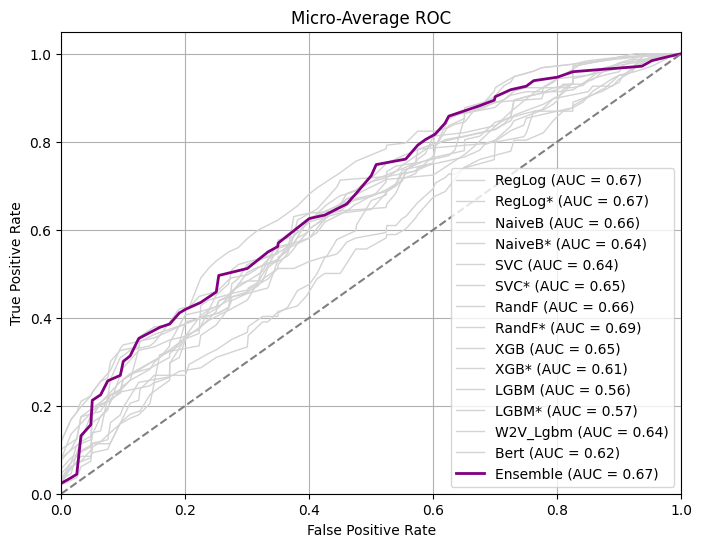

In [ ]:
plt.figure(figsize=(8, 6))

for i, y_pred_probabilities in enumerate(probas):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = len(class_labels)
    for j in range(n_classes):
        y_true_class = (y_true_encoded == j).astype(int)
        fpr[j], tpr[j], _ = roc_curve(y_true_class, y_pred_probabilities[:, j])
        roc_auc[j] = auc(fpr[j], tpr[j])

    all_fpr = np.unique(np.concatenate([fpr[j] for j in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)

    for j in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])

    mean_tpr /= n_classes
    roc_auc_micro = auc(all_fpr, mean_tpr)

    if i == len(probas) - 1:
        plt.plot(all_fpr, mean_tpr, lw=2, label=f'{model_names[i]} (AUC = {roc_auc_micro:.2f})', color='purple')
    else:
        plt.plot(all_fpr, mean_tpr, lw=1, label=f'{model_names[i]} (AUC = {roc_auc_micro:.2f})', color='lightgray')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Micro-Average ROC')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


### Evaluación

In [ ]:
print("Accuracy: {:.2f}%".format(accuracy_score(y_test, prob_ensemble["Ensemble Label"].to_list()) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(y_test, prob_ensemble["Ensemble Label"].to_list(), average='weighted') * 100))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, prob_ensemble["Ensemble Label"].to_list()))

Accuracy: 66.99%

F1 Score: 63.18

Confusion Matrix:
 [[57  6]
 [28 12]]


In [ ]:
prob_ensemble.to_excel('ypf_predicciones_ensemble_power.xlsx', index=False)